In [2]:
#Importações iniciais
import pandas as pd 
import csv
import numpy as np

In [3]:
#leitura do .csv gerado na etapa anterior
try:
    
    df = pd.read_csv('data/dados_consolidados_final.csv',)
except Exception as e:
    print(f"Erro crítico na leitura: {e}")

In [4]:
df

,CNPJ,Razao_Social,Ano,Trimestre,ValorDespesas
0,00006037000127,UNIMED DE TATUI - COOPERATIVA DE TRABALHO MÃDICO,2025,1,5.362444e+06
1,00006037000127,UNIMED DE TATUI - COOPERATIVA DE TRABALHO MÃDICO,2025,2,4.730002e+06
2,00006037000127,UNIMED DE TATUI - COOPERATIVA DE TRABALHO MÃDICO,2025,3,1.268016e+08
3,00012698000165,UNIMED DE PENAPOLIS - COOPERATIVA DE TRABALHO ...,2025,1,7.851127e+06
4,00012698000165,UNIMED DE PENAPOLIS - COOPERATIVA DE TRABALHO ...,2025,2,7.142542e+06
...,...,...,...,...,...
2338,97553801000116,PLURAL GESTÃO EM PLANOS DE SAÃDE LTDA,2025,2,-3.192782e+07
2339,97553801000116,PLURAL GESTÃO EM PLANOS DE SAÃDE LTDA,2025,3,9.232044e+06
2340,NAO_ENCONTRADO,NAO_ENCONTRADO,2025,1,1.024868e+09
2341,NAO_ENCONTRADO,NAO_ENCONTRADO,2025,2,5.880955e+08


## Validações de Dados

In [5]:
#Padronizando o CNPJ
df['CNPJ_limpo'] = (df['CNPJ'].astype(str).str.replace(r'\D', '', regex=True))


In [6]:
##Regras Básicas de CNPJ válido
cnpj = df['CNPJ_limpo']

df['cnpj_basico_valido'] = ((cnpj.str.len() == 14) & (~cnpj.str.match(r'^(\d)\1{13}$')))


In [7]:
# Função de validação dos digitos no CNPJ , se não estão negativos e se estão no tamanho apropriado
def validar_digito(cnpj):
    pesos1 = [5,4,3,2,9,8,7,6,5,4,3,2]
    pesos2 = [6] + pesos1

    def digito(base, pesos):
        soma = sum(int(d)*p for d, p in zip(base, pesos))
        resto = soma % 11
        return '0' if resto < 2 else str(11 - resto)

    d1 = digito(cnpj[:12], pesos1)
    d2 = digito(cnpj[:12] + d1, pesos2)

    return cnpj[-2:] == d1 + d2

In [8]:
# aplica a função para verificação dos dígitos 
df['cnpj_valido'] = False

mask = df['cnpj_basico_valido']
df.loc[mask, 'cnpj_valido'] = (df.loc[mask, 'CNPJ_limpo'].apply(validar_digito))


In [9]:
# Valida a Razao Social
df['razao_valida'] = (df['Razao_Social'].notna() & df['Razao_Social'].str.strip().ne(''))


In [10]:
# Valida a o valor das despesas e Confere se está como Positva nas células
df['valor_valido'] = df['ValorDespesas'].ge(0)


In [11]:
# Confere agora quantos erros possui 
erros = df[ (~df['cnpj_valido']) | (~df['razao_valida']) |(~df['valor_valido']) ]

print(f"Total de registros com problema: {len(erros)}")
erros.head()


Total de registros com problema: 101


,CNPJ,Razao_Social,Ano,Trimestre,ValorDespesas,CNPJ_limpo,cnpj_basico_valido,cnpj_valido,razao_valida,valor_valido
31,00304148000110,FUNDAÃÃO DE SAÃDE ITAIGUAPY,2025,2,-12029791.0,00304148000110,True,True,True,False
40,00342481000113,UNIMED CALDAS NOVAS - COOPERATIVA DE TRABALHO ...,2025,2,-1591685.0,00342481000113,True,True,True,False
68,00494870000164,UNIMED DE IBITINGA COOPERATIVA DE TRABALHO MÃ...,2025,3,-153392.0,00494870000164,True,True,True,False
81,00580481000151,FUNDACAO CAPITAL PREVIDENCIA E SAUDE - CAPITAL...,2025,2,-770726.0,00580481000151,True,True,True,False
145,01012474000116,UNIMED PONTE NOVA COOPERATIVA DE TRABALHO MEDI...,2025,1,-307472.0,01012474000116,True,True,True,False


## Tratamento desses CNPJs Inválidos

In [12]:
# Criação de verificação de se está inválido ou ok
df['cnpj_status'] = 'ok'
df.loc[~df['cnpj_valido'], 'cnpj_status'] = 'invalido'


In [13]:
df['cnpj_status'].value_counts()


cnpj_status
ok          2340
invalido       3
Name: count, dtype: int64

In [14]:
df['registro_valido'] = (
    df['cnpj_valido'] &
    df['razao_valida'] &
    df['valor_valido']
)


In [15]:
df['valor_status'] = np.where(
    df['ValorDespesas'] < 0, 'negativo',
    np.where(df['ValorDespesas'] == 0, 'zero', 'positivo')
)

df['valor_status'].describe


<bound method NDFrame.describe of 0       positivo
1       positivo
2       positivo
3       positivo
4       positivo
          ...   
2338    negativo
2339    positivo
2340    positivo
2341    positivo
2342    positivo
Name: valor_status, Length: 2343, dtype: object>

In [16]:
# Selecionando o local de trabalho com esses erros
df_problemas = df[~df['cnpj_valido']]
df_ok = df[df['cnpj_valido']]


In [17]:
# localização de erros como negativos ou zeros
df_problemas = df[df['valor_status'].isin(['negativo', 'zero'])]
df_problemas.head()


,CNPJ,Razao_Social,Ano,Trimestre,ValorDespesas,CNPJ_limpo,cnpj_basico_valido,cnpj_valido,razao_valida,valor_valido,cnpj_status,registro_valido,valor_status
31,00304148000110,FUNDAÃÃO DE SAÃDE ITAIGUAPY,2025,2,-12029791.0,00304148000110,True,True,True,False,ok,False,negativo
40,00342481000113,UNIMED CALDAS NOVAS - COOPERATIVA DE TRABALHO ...,2025,2,-1591685.0,00342481000113,True,True,True,False,ok,False,negativo
68,00494870000164,UNIMED DE IBITINGA COOPERATIVA DE TRABALHO MÃ...,2025,3,-153392.0,00494870000164,True,True,True,False,ok,False,negativo
81,00580481000151,FUNDACAO CAPITAL PREVIDENCIA E SAUDE - CAPITAL...,2025,2,-770726.0,00580481000151,True,True,True,False,ok,False,negativo
145,01012474000116,UNIMED PONTE NOVA COOPERATIVA DE TRABALHO MEDI...,2025,1,-307472.0,01012474000116,True,True,True,False,ok,False,negativo


In [18]:
#Contagem erros 
df['valor_status'].value_counts()


valor_status
positivo    2244
negativo      98
zero           1
Name: count, dtype: int64

In [19]:
#Tratamento dops zeros
df_zero = df[df['valor_status'] == 'zero']
df_zero

,CNPJ,Razao_Social,Ano,Trimestre,ValorDespesas,CNPJ_limpo,cnpj_basico_valido,cnpj_valido,razao_valida,valor_valido,cnpj_status,registro_valido,valor_status
1056,25063964000100,FUNDAÃÃO DE ASSISTÃNCIA Ã SAÃDE DA ASSOCI...,2025,2,0.0,25063964000100,True,True,True,True,ok,True,zero


In [20]:
# Em regras de negócio podemos ter valores negativos então ideal é tomarmos cuidado e pensarmoso oque vamos fazer
df_negativos = df[df['valor_status'] == 'negativo']
df_negativos

,CNPJ,Razao_Social,Ano,Trimestre,ValorDespesas,CNPJ_limpo,cnpj_basico_valido,cnpj_valido,razao_valida,valor_valido,cnpj_status,registro_valido,valor_status
31,00304148000110,FUNDAÃÃO DE SAÃDE ITAIGUAPY,2025,2,-12029791.0,00304148000110,True,True,True,False,ok,False,negativo
40,00342481000113,UNIMED CALDAS NOVAS - COOPERATIVA DE TRABALHO ...,2025,2,-1591685.0,00342481000113,True,True,True,False,ok,False,negativo
68,00494870000164,UNIMED DE IBITINGA COOPERATIVA DE TRABALHO MÃ...,2025,3,-153392.0,00494870000164,True,True,True,False,ok,False,negativo
81,00580481000151,FUNDACAO CAPITAL PREVIDENCIA E SAUDE - CAPITAL...,2025,2,-770726.0,00580481000151,True,True,True,False,ok,False,negativo
145,01012474000116,UNIMED PONTE NOVA COOPERATIVA DE TRABALHO MEDI...,2025,1,-307472.0,01012474000116,True,True,True,False,ok,False,negativo
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2261,88258884000120,UNIMED VALE DO SINOS - COOPERATIVA DE ASSISTÃ...,2025,2,-22526093.0,88258884000120,True,True,True,False,ok,False,negativo
2303,92316124000107,UNIMED REGIÃO DA FRONTEIRA - RS COOPERATIVA D...,2025,2,-638469.0,92316124000107,True,True,True,False,ok,False,negativo
2327,96396395000162,UNIODONTO PAULISTA-FEDERAÃÃO DAS COOPERATIVA...,2025,2,-200976.0,96396395000162,True,True,True,False,ok,False,negativo
2334,97388490000187,UNIMED COSTA DO DESCOBRIMENTO COOPERATIVA DE T...,2025,3,-4658987.0,97388490000187,True,True,True,False,ok,False,negativo


In [21]:
# Verificação do CNPJs errados 
df['cnpj_valido'].value_counts()

cnpj_valido
True     2340
False       3
Name: count, dtype: int64

In [22]:
# Isolandoos do resto 
df_cnpj_invalidos = df[df['cnpj_valido'] == False]
df_cnpj_invalidos


,CNPJ,Razao_Social,Ano,Trimestre,ValorDespesas,CNPJ_limpo,cnpj_basico_valido,cnpj_valido,razao_valida,valor_valido,cnpj_status,registro_valido,valor_status
2340,NAO_ENCONTRADO,NAO_ENCONTRADO,2025,1,1.024868e+09,,False,False,True,True,invalido,False,positivo
2341,NAO_ENCONTRADO,NAO_ENCONTRADO,2025,2,5.880955e+08,,False,False,True,True,invalido,False,positivo
2342,NAO_ENCONTRADO,NAO_ENCONTRADO,2025,3,2.044332e+08,,False,False,True,True,invalido,False,positivo


In [23]:
# nesse processo foi ncriado muitas colunas qyue podem e devem ser excluidas
df.columns

Index(['CNPJ', 'Razao_Social', 'Ano', 'Trimestre', 'ValorDespesas',
       'CNPJ_limpo', 'cnpj_basico_valido', 'cnpj_valido', 'razao_valida',
       'valor_valido', 'cnpj_status', 'registro_valido', 'valor_status'],
      dtype='object')

In [24]:
colunas_finais = ['CNPJ', 'Razao_Social', 'Ano', 'Trimestre', 'ValorDespesas','cnpj_valido']

df = df[colunas_finais].copy()


In [25]:
#Finalmente deixando o Dataset Limpo titrando os CNPJs 
df_limpo = df[df['cnpj_valido']]
df_limpo


,CNPJ,Razao_Social,Ano,Trimestre,ValorDespesas,cnpj_valido
0,00006037000127,UNIMED DE TATUI - COOPERATIVA DE TRABALHO MÃDICO,2025,1,5362444.0,True
1,00006037000127,UNIMED DE TATUI - COOPERATIVA DE TRABALHO MÃDICO,2025,2,4730002.0,True
2,00006037000127,UNIMED DE TATUI - COOPERATIVA DE TRABALHO MÃDICO,2025,3,126801594.0,True
3,00012698000165,UNIMED DE PENAPOLIS - COOPERATIVA DE TRABALHO ...,2025,1,7851127.0,True
4,00012698000165,UNIMED DE PENAPOLIS - COOPERATIVA DE TRABALHO ...,2025,2,7142542.0,True
...,...,...,...,...,...,...
2335,97403778000183,SOCIODONTO PLANO DE ASSISTÃNCIA ODONTOLÃGICA...,2025,1,1223078.0,True
2336,97403778000183,SOCIODONTO PLANO DE ASSISTÃNCIA ODONTOLÃGICA...,2025,3,2387221.0,True
2337,97553801000116,PLURAL GESTÃO EM PLANOS DE SAÃDE LTDA,2025,1,3036100.0,True
2338,97553801000116,PLURAL GESTÃO EM PLANOS DE SAÃDE LTDA,2025,2,-31927818.0,True


# Iniciando o Join

In [26]:
# tabela com as localidades
cadastro = pd.read_csv("data/Relatorio_cadop.csv", sep=";", dtype=str)


In [27]:
# Manter somente as colunas úteis 
cadastro = cadastro[['CNPJ', 'REGISTRO_OPERADORA', 'Modalidade', 'UF']]

In [28]:
# Padronizar os nomes nas duas tabelas
cadastro = cadastro.rename(columns={'REGISTRO_OPERADORA': 'RegistroANS'})

In [29]:
# Limpar CNPJ 
cadastro['CNPJ'] = cadastro['CNPJ'].str.replace(r'\D', '', regex=True)

In [30]:
cadastro

,CNPJ,RegistroANS,Modalidade,UF
0,19541931000125,419761,Administradora de Benefícios,MG
1,22869997000153,421545,Odontologia de Grupo,SP
2,27452545000195,421421,Medicina de Grupo,SP
3,13138885000131,418030,Administradora de Benefícios,SP
4,17505793000101,314668,Autogestão,MG
...,...,...,...,...
1105,58014237000101,424315,Administradora de Benefícios,RJ
1106,14927215000167,419354,Odontologia de Grupo,SP
1107,02811372000123,400882,Odontologia de Grupo,SP
1108,28023703000154,407534,Medicina de Grupo,RJ


In [31]:
# verificando os duplicados
duplicados = cadastro[cadastro.duplicated('CNPJ', keep=False)]

print(f"CNPJs duplicados no cadastro: {duplicados['CNPJ'].nunique()}")


CNPJs duplicados no cadastro: 0


In [32]:
# Resolver mantendo o primeiro
cadastro = cadastro.drop_duplicates(subset='CNPJ', keep='first')

# Unindo as Tabelas

In [33]:
# finalmente Unindo as tabelas
df_final_enriquecido = df_limpo.merge(
    cadastro,
    on='CNPJ',
    how='left'
)

In [34]:
df_final_enriquecido

,CNPJ,Razao_Social,Ano,Trimestre,ValorDespesas,cnpj_valido,RegistroANS,Modalidade,UF
0,00006037000127,UNIMED DE TATUI - COOPERATIVA DE TRABALHO MÃDICO,2025,1,5362444.0,True,361941,Cooperativa Médica,SP
1,00006037000127,UNIMED DE TATUI - COOPERATIVA DE TRABALHO MÃDICO,2025,2,4730002.0,True,361941,Cooperativa Médica,SP
2,00006037000127,UNIMED DE TATUI - COOPERATIVA DE TRABALHO MÃDICO,2025,3,126801594.0,True,361941,Cooperativa Médica,SP
3,00012698000165,UNIMED DE PENAPOLIS - COOPERATIVA DE TRABALHO ...,2025,1,7851127.0,True,323004,Cooperativa Médica,SP
4,00012698000165,UNIMED DE PENAPOLIS - COOPERATIVA DE TRABALHO ...,2025,2,7142542.0,True,323004,Cooperativa Médica,SP
...,...,...,...,...,...,...,...,...,...
2335,97403778000183,SOCIODONTO PLANO DE ASSISTÃNCIA ODONTOLÃGICA...,2025,1,1223078.0,True,416410,Odontologia de Grupo,MG
2336,97403778000183,SOCIODONTO PLANO DE ASSISTÃNCIA ODONTOLÃGICA...,2025,3,2387221.0,True,416410,Odontologia de Grupo,MG
2337,97553801000116,PLURAL GESTÃO EM PLANOS DE SAÃDE LTDA,2025,1,3036100.0,True,418552,Administradora de Benefícios,RJ
2338,97553801000116,PLURAL GESTÃO EM PLANOS DE SAÃDE LTDA,2025,2,-31927818.0,True,418552,Administradora de Benefícios,RJ


In [35]:
# testando o join
sem_match = df_final_enriquecido['RegistroANS'].isna().sum()
print(f"Registros sem match no cadastro: {sem_match}")

Registros sem match no cadastro: 0


In [36]:
df_final_enriquecido.to_csv("data/dados_operadoras_cadastrais.csv",index=False,encoding="utf-8")

# Agregação Estratégica

In [37]:
# Agregando as tabelas e tirando métricas
df_agregado = (
    df_final_enriquecido.groupby(['Razao_Social', 'UF']).agg(
            total_despesas=('ValorDespesas', 'sum'),
            media_trimestral=('ValorDespesas', 'mean'),
            desvio_padrao=('ValorDespesas', 'std')
        ).reset_index())


In [38]:
df_agregado = df_agregado.sort_values(by='total_despesas',ascending=False)


In [39]:
df_agregado

,Razao_Social,UF,total_despesas,media_trimestral,desvio_padrao
126,BRADESCO SAÃDE S.A.,RJ,1.195806e+11,3.986021e+10,1.354334e+10
177,CLINIPAM CLINICA PARANAENSE DE ASSISTENCIA MED...,CE,1.756154e+10,5.853846e+09,5.671129e+09
252,H.B. SAÃDE S/A.,SP,1.453284e+10,4.844281e+09,5.061139e+08
171,CENTRO CLÃNICO GAÃCHO LTDA,CE,7.281480e+09,2.427160e+09,7.429013e+07
240,FUNDAÃÃO SÃO FRANCISCO XAVIER,MG,6.117217e+09,2.039072e+09,1.483151e+08
...,...,...,...,...,...
229,FUNDAÃÃO CHESF DE ASSISTÃNCIA E SEGURIDADE ...,PE,-1.156550e+08,-3.855166e+07,6.635931e+07
10,ALLCARE ADMINISTRADORA DE BENEFÃCIOS EM SAÃD...,DF,-4.250228e+08,-1.416743e+08,4.020352e+06
9,ALL CARE ADMINISTRADORA DE BENEFÃCIOS SÃO PA...,SP,-5.121747e+08,-1.707249e+08,1.899540e+07
332,ODONTOPREV S/A,SP,-8.850471e+08,-2.950157e+08,3.203293e+08


In [40]:
# Transformando em um novo .csv com tudo agregado
df_agregado.to_csv("data/despesas_agregadas.csv",index=False,encoding="utf-8")


c:\Users\luisf\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 154 (\x9a) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\luisf\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 141 (\x8d) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\luisf\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 135 (\x87) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\luisf\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 131 (\x83) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\luisf\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 137 (\x89) missing from font(s) 

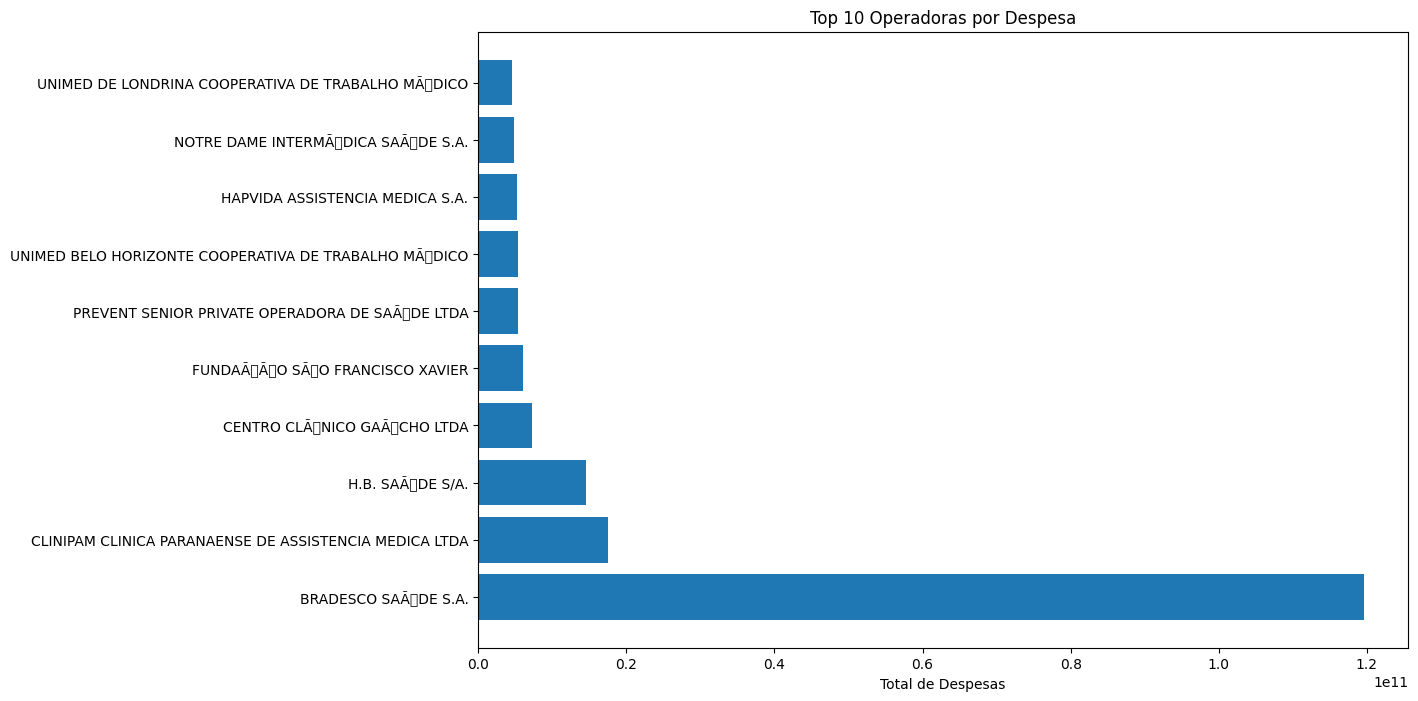

In [41]:
# Apenas para melhor entendimento dos dados irei usar essa demonstração simples com matplotlib
import matplotlib.pyplot as plt

top10 = df_agregado.head(10)

plt.figure(figsize=(12,8))
plt.barh(top10['Razao_Social'], top10['total_despesas'])
plt.xlabel("Total de Despesas")
plt.title("Top 10 Operadoras por Despesa")
plt.show()


### Zipando o csv

In [42]:
import zipfile


nome_zip = "Teste_Luis_Filipe_Moreira_novais.zip"
nome_csv = "data/dados_consolidados_final.csv"

with zipfile.ZipFile(nome_zip, 'w', compression=zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(nome_csv)

print(f"Arquivo {nome_zip} criado com sucesso!")

Arquivo Teste_Luis_Filipe_Moreira_novais.zip criado com sucesso!
